This notebook will specifically use data from the Allen Insitute for Neural Dynamics (available on the associated Code Ocean capsule in the data folder) and show how we can leverage CEBRA to analyse our in-house data. 

Here, the functions in the cebra tools package are defined, you can find them in the utils script in cebra_pack: format_data(), build_train_compute() and view_emebddings().

In [1]:
import sys
import os # my addtion

import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.data
import torch
import cebra.integrations
import cebra.datasets
from cebra import CEBRA
import torch
import pickle
import cebra_pack.utils as cp


from matplotlib.collections import LineCollection
import pandas as pd

## A. Load the Data

Here we load data from the Fibre Photometry pipeline of 4 Neuromodulators (DA, 5HT, ACh, NE) recorded in the Nucleus Acumbens region. The main neural data will be in the form of dF_F traces of these 4 Neuromodulators (NMs). These will be stored in a 2D array, 'all_nms'.

In [2]:
# load the dataframe that contains data from 1 session (you can download this locally and replcace the path) -- need at least pandas 2.0.0
try:
    df_trials_ses = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/df.pkl', "rb"))
    print("Loaded df.pkl from the local path.")
except FileNotFoundError:
    df_trials_ses = pickle.load(open('/data/df.pkl', "rb"))
    print("Loaded df.pkl from the CO path.")

Loaded df.pkl from the local path.


In [3]:
# let's see how it looks
df_trials_ses

,bit_code,ses_idx,rpe,left_action_value,right_action_value,licks L,licks R,Lick L (raw),Lick R (raw),trial,...,reward_time,onset,NM,NM_name,region,last_value_NM,overlap_index,NM_no_overlap,bins_mids,bins_mids_no_overlap
0,00110001111001010011,632106_2022-08-23,1.000000,0.000000e+00,0.327773,26.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,...,92.362000,"[-1.0, -0.9500000000000028, -0.900000000000005...","[-0.006876904734641623, -0.007146692736817482,...",DA,NAc,NaN,0,"[-0.006876904734641623, -0.007146692736817482,...","[-0.9750000000000014, -0.9250000000000043, -0....","[91.05000152587891, 91.1000015258789, 91.15000..."
1,10101101011111010011,632106_2022-08-23,-0.327773,0.000000e+00,0.222074,10.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.09396514270492158, 0.09166120346690362, 0.0...",DA,NAc,0.074671,18,"[0.07467145399912882, 0.07390178461889173, 0.0...","[-0.9750000000000014, -0.9250000000000043, -0....","[100.83500366210933, 100.88500366210931, 100.9..."
2,10110000011000010100,632106_2022-08-23,-0.222074,0.000000e+00,0.150461,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.03888178725609381, 0.03576014157991385, 0.0...",DA,NAc,0.111702,18,"[0.1117021239456095, 0.1111829908404548, 0.114...","[-0.9750000000000014, -0.9250000000000043, -0....","[108.38499908447261, 108.4349990844726, 108.48..."
3,10111100010010100001,632106_2022-08-23,-0.150461,0.000000e+00,0.101941,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.04022817060438801, 0.04426318323498179, 0.0...",DA,NAc,0.039222,19,"[0.039221979243197015, 0.04083176200307425, 0....","[-0.9750000000000014, -0.9250000000000043, -0....","[113.19799957275384, 113.24799957275386, 113.2..."
4,01101111100010011111,632106_2022-08-23,-0.101941,0.000000e+00,0.069068,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4,...,NaN,"[-1.0, -0.9500000000000028, -0.900000000000005...","[0.027914873653080343, 0.028333289056160112, 0...",DA,NAc,0.023959,19,"[0.023959280634978056, 0.02501534419509218, 0....","[-0.9750000000000014, -0.9250000000000043, -0....","[117.01500091552728, 117.06500091552729, 117.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1760,00011101000011111011,632106_2022-08-23,-0.824473,1.198410e-05,0.558602,1.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1754,...,NaN,"[-1.0, -0.9500000000007276, -0.900000000001455...","[-0.0012799915180941783, -0.000190254206188288...",ACh,NAc,0.001646,19,"[0.0016461378021336635, -0.0003314239969927528...","[-0.9750000000003638, -0.9250000000010914, -0....","[10949.811914062486, 10949.861914062485, 10949..."
1761,00000100001000111000,632106_2022-08-23,0.441398,5.779060e-06,0.703280,3.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1755,...,10954.419922,"[-1.0, -0.9500000000007276, -0.900000000001455...","[0.002407675576329689, 0.004578818551264469, 0...",ACh,NAc,0.000260,18,"[0.00026042376397175855, 0.0025022589975745445...","[-0.9750000000003638, -0.9250000000010914, -0....","[10954.139843749987, 10954.189843749986, 10954..."
1762,01011100011001010000,632106_2022-08-23,0.296720,2.786810e-06,0.800537,2.0,0.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1756,...,10960.533203,"[-1.0, -0.9500000000007276, -0.900000000001455...","[0.004071718630667636, 0.0019159427498036115, ...",ACh,NAc,0.005961,19,"[0.00596118894201

In [4]:
df_trials_ses.columns

Index(['bit_code', 'ses_idx', 'rpe', 'left_action_value', 'right_action_value',
       'licks L', 'licks R', 'Lick L (raw)', 'Lick R (raw)', 'trial', 'reward',
       'choice', 'go_cue_absolute_time', 'go_cue', 'choice_time',
       'reward_time', 'onset', 'NM', 'NM_name', 'region', 'last_value_NM',
       'overlap_index', 'NM_no_overlap', 'bins_mids', 'bins_mids_no_overlap'],
      dtype='object')

In [5]:
df_trials_ses[['choice_time', 'NM']]

,choice_time,NM
0,92.321007,"[-0.006876904734641623, -0.007146692736817482,..."
1,101.023003,"[0.09396514270492158, 0.09166120346690362, 0.0..."
2,108.575996,"[0.03888178725609381, 0.03576014157991385, 0.0..."
3,113.322006,"[0.04022817060438801, 0.04426318323498179, 0.0..."
4,117.152000,"[0.027914873653080343, 0.028333289056160112, 0..."
...,...,...
1760,10949.992188,"[-0.0012799915180941783, -0.000190254206188288..."
1761,10954.376953,"[0.002407675576329689, 0.004578818551264469, 0..."
1762,10960.488281,"[0.004071718630667636, 0.0019159427498036115, ..."
1763,10965.165039,"[0.0028887586184446284, -0.0004695738273102596..."


NB: There's 1765 trials in this data frame (the indices are repeated over each neuromodulator)
all information is in the first 1765 rows so we'll consider those

In [6]:
n_trials = 1765

In [7]:
# download the dictionary containing the traces (you can download this locally and replcace the path)
try:
    traces = pickle.load(open('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/traces.pkl', "rb"))
    print("Loaded traces.pkl from the local path.")
except FileNotFoundError:
    traces = pickle.load(open('/data/traces.pkl', "rb"))
    print("Loaded traces.pkl from the alternate path.")

Loaded traces.pkl from the local path.


In [8]:
# load the trace times (you can download this locally and replcace the path)
try:
    trace_times = np.load('/Users/brian.gitahi/Desktop/AIND/CEBRA/Git/CEBRA-Demo/data/CO data/Trace times.npy', allow_pickle=True)
    print("Loaded Trace times.npy from the local path.")
except FileNotFoundError:
    trace_times = np.load('/data/Trace times.npy', allow_pickle=True)
    print("Loaded Trace times.npy from the alternate path.")

Loaded Trace times.npy from the local path.


In [9]:
# get the choice time 
choice_times = df_trials_ses['choice_time'][0:n_trials].to_numpy()

In [10]:
# Combine the traces into one 2D array
all_nms = np.array([traces[trace] for trace in traces.keys()])
all_nms = np.transpose(all_nms)

# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape


(218572, 4)

In [11]:
all_nms.shape

(218572, 4)

In [12]:
# change it to an array of floats (previously it was an array of object datatype)
all_nms_new = all_nms.astype(np.float64)
all_nms_new.shape

(218572, 4)

In [13]:
# convert it to a tensor (this is probably not necessary but we want it to be as close to the inputs in the previous notebook)
all_nms_tensor = torch.from_numpy(all_nms_new)
all_nms_tensor.shape

torch.Size([218572, 4])

## B. Format data and create the behavioural/auxiliary variables

Now let's format the data. We want to view the data in a 1 second window around the choice time at each trial in the session. The hope is that this will make it easy to identify the presence/absence of reward in the neuromodulator signal.

Each trial will be labelled as rewarded/unrewarded and this will be the behavioural variable we use for this analysis.

In [14]:
# Make a function to format the NM data into a 1s window around the choice

def format_data(neural_data, df, trace_times_, choice_times_ , window=None , window_size=10, n_trials=1765):

    # define the number of trials where the mouse made a choice
    n_choice_trials = np.unique(np.isnan(choice_times_),return_counts=True)[1][0]

    # list to hold all the 1s windows
    n_data_window = []

    # new trial label
    trial_labels = []

    # loop over all trials
    for i in range(0,n_trials):

        # skip trials where the animal didn't make a choice (null choice time)
        if np.isnan(choice_times_[i]):
            continue

        # find the index of the closest time to the choice time in the trace_times array 
        idx = np.abs(trace_times_ - choice_times_[i]).argmin()

        # take the previous 10 and/or the next 10 values of the NM data at these indices - 1s window
        if window =='before':
            n_data_window.append(neural_data[idx-10:idx])

        if window == 'after':
            n_data_window.append(neural_data[idx:idx+10])

        if window == None:
            n_data_window.append(neural_data[idx-10:idx+10])

        # label the timepoints as rewarded or unrewarded
        if df['reward'].iloc[i]:
            # new trial label
            trial_labels.append(1)

        elif df['reward'].iloc[i]==False:
            # new trial label
            trial_labels.append(0)


    # stack the nm data for each trial
    nms_HD = np.stack(n_data_window).reshape((n_choice_trials,-1))
    # format it into a tensor
    nms_HD = torch.from_numpy(nms_HD.astype(np.float64))
    print("neural tensor shape: ", nms_HD.shape)

    # convert trial labels into an array
    trial_labels = np.array(trial_labels)
    print("labels shape: ",trial_labels.shape)

    return nms_HD, trial_labels

In [15]:
formatted_nms, trial_labels = format_data(all_nms,df=df_trials_ses,trace_times_=trace_times, choice_times_=choice_times)

neural tensor shape:  torch.Size([1717, 80])
labels shape:  (1717,)


Out of the 1765 trials in the session, this particular mouse made a choice in 1717 of them. So we will only use those trials. Therefore we have a binary array of shape (1717,) as our behavioural label. The NM data is organized such that we have 20 timesteps for each of the 4 neuromodulators in this 1 second window.

## C. Build and train the CEBRA models

This section will be summarized as a function in later notebooks. The function can be accessed from the package cebra_pack: build_train_compute() 

In [16]:
# set the maximum number of iterations for training the model
max_iterations = 2000

In [17]:
# build a CEBRA-Time and CEBRA-Behaviour model
cebra_time_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [18]:
cebra_behaviour_model = CEBRA(model_architecture='offset10-model-mse',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='euclidean',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

Train the two models

In [19]:
# train the time model (no labels here)
cebra_time_model.fit(formatted_nms)

pos:  0.9518 neg:  2.8770 total:  3.8288 temperature:  1.0000: 100%|██████████| 2000/2000 [00:34<00:00, 58.24it/s]


CEBRA(batch_size=512, conditional='time', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

In [20]:
# train the behaviour model (use the labels here)
cebra_behaviour_model.fit(formatted_nms, trial_labels)

pos:  0.2903 neg:  5.4378 total:  5.7282 temperature:  1.0000: 100%|██████████| 2000/2000 [00:37<00:00, 52.92it/s]


CEBRA(batch_size=512, conditional='time_delta', distance='euclidean',
      max_iterations=2000, model_architecture='offset10-model-mse',
      output_dimension=3, temperature=1, time_offsets=10, verbose=True)

## D. Compute and view embeddings

Here, we compute the embeddings from the two trained models and then plot them.

In [21]:
time_embedding = cebra_time_model.transform(formatted_nms)

In [22]:
behaviour_embedding = cebra_behaviour_model.transform(formatted_nms)

In [23]:
# divide the labels into rewarded and unrewarded
rewarded_ = trial_labels==1
unrewarded_ = trial_labels==0

rewarded_ = rewarded_.flatten()
unrewarded_ = unrewarded_.flatten()

In [24]:
# sanity check - confirm that there's only two possibilities and that they add up to the total # of trials
print('Unique values (and their corresponding counts in the labels:',np.unique(unrewarded_, return_counts=True))

print('Embedding (time) shape:',time_embedding.shape)
print('Embedding (behaviour) shape:',behaviour_embedding.shape)

print("Difference between the length of embedding array and the total number of trials:",np.sum(time_embedding.shape[0] - np.sum(np.unique(unrewarded_, return_counts=True)[1])))

Unique values (and their corresponding counts in the labels: (array([False,  True]), array([ 573, 1144]))
Embedding (time) shape: (1717, 3)
Embedding (behaviour) shape: (1717, 3)
Difference between the length of embedding array and the total number of trials: 0


Text(0.5, 0, 'latent 3')

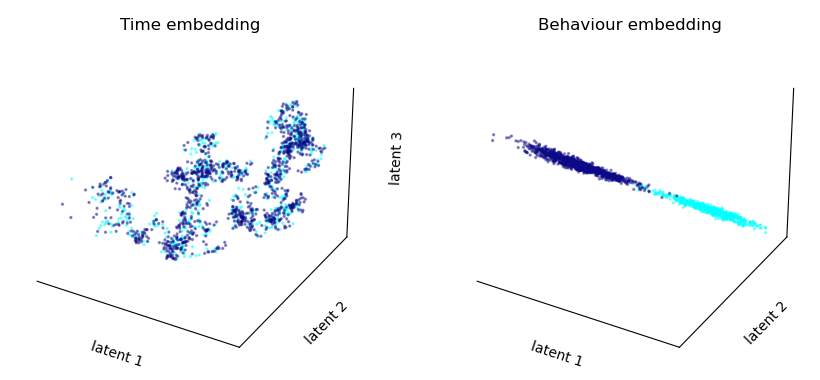

In [25]:
# create a figure and make the plots
#%matplotlib inline
fig1 = plt.figure(figsize=(16,4))
gs = gridspec.GridSpec(1, 2, figure=fig1)

ax1 = fig1.add_subplot(gs[0,0], projection='3d')
ax2 = fig1.add_subplot(gs[0,1], projection='3d')
axes =[ax1,ax2]

for ax in axes:


    ax.set_xlabel("latent 1", labelpad=0.01)
    ax.set_ylabel("latent 2", labelpad=0.01)
    ax.set_zlabel("latent 3", labelpad=0.01)

    # Hide X and Y axes label marks
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.yaxis.set_tick_params(labelleft=False)
    ax.zaxis.set_tick_params(labelright=False)

    # Hide X and Y axes tick marks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])


# colour maps
colours = ['cool', 'plasma']

# plot the time embedding 
cebra.plot_embedding(embedding=time_embedding[rewarded_,:], embedding_labels=trial_labels[rewarded_],ax=ax1, markersize=2, title='Time embedding', cmap=colours[0])
cebra.plot_embedding(embedding=time_embedding[unrewarded_,:], embedding_labels=trial_labels[unrewarded_],ax=ax1, markersize=2, title='Time embedding', cmap=colours[1])

# plot the behaviour embedding 
cebra.plot_embedding(embedding=behaviour_embedding[rewarded_,:], embedding_labels=trial_labels[rewarded_],ax=ax2, markersize=2, title='Behaviour embedding', cmap=colours[0],)
cebra.plot_embedding(embedding=behaviour_embedding[unrewarded_,:], embedding_labels=trial_labels[unrewarded_],ax=ax2,markersize=2, title='Behaviour embedding',  cmap=colours[1])


# Adjust the subplot layout manually
#plt.subplots_adjust(left=0.095, right=0.1, top=0.95, bottom=0.05, wspace=0.001)

# Adjust the subplot layout manually
plt.subplots_adjust(left=0.00001, right=0.55, top=0.95, bottom=0.05, wspace=0.0001)

# Use tight_layout with padding to ensure labels are not cut off


# Adjust label positions using bbox
ax2.set_zlabel("latent 3", labelpad=1, fontsize=10, bbox=dict(facecolor='white', edgecolor='none', pad=0.5))


From this pair of embeddings we can see that there is a clustering of the rewarded (light blue) and unrewarded (purple) trials when we use CEBRA behaviour.